### Skill, biases, and other properties of intermediate variables
Intermediate variables are dynamic timeseries of potential relevance

Evaluation of simple-average variable skill happens through the comparison object (some bookkeeping required)
* Reguires a matched frame
* Requires a climatology (for the threshold, or for m member samples in case of CRPS). Multiple climatologies might be needed. Also low thresholds if skill in soilm depletion is desired.
* Requires a (leadtime dependent) modelclimatology (if spread differences can be expected).
* Can also show trends in the binarized version of the variable.

Evaluation of regimes cannot happen through the comparison framework.
* loading as a matched frame.
* Hard and soft (aggregated) evaluation.
* Frequency biases (perhaps conditional).
* Frequency bias the consequence of a persistence bias? (transition probabilities?).

Evaluation of just bias, or year to year variation
* Comparing ensemble mean to observation over all data-points
* Checking for trends
* Error/bias conditional on other variables / time periods.
* Autocorrelation function for persistence?

What could be conditional biases?
* Under-persistence of blocking more severe when soil moisture is dry? (not neccesarily initialization).
* Based on high signal in osso SST regions?
* Extra biases in blocking regime when regime X is in the initialization?

In [1]:
import sys
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from scipy.stats import gaussian_kde

from observations import Climatology
from comparison import ForecastToObsAlignment, Comparison
from forecasts import ModelClimatology

sys.path.append(os.path.expanduser('~/Documents/Weave'))
from Weave.models import BaseExceedenceModel # This is a subclass of sklearn.linear_model.LogisticRegression

### Dataframe with available intermediate variables.
The old 7D versions of sst, z and swvl use the few cluster version of -simple-mean. 

In [4]:
interm_vars = pd.DataFrame({'obs':['sst-anom_1998-06-07_2019-08-31_7D-roll-mean_1-sst-simple-mean',
                                   'sst-anom_1998-06-07_2019-08-31_14D-roll-mean_1-sst-simple-mean',
                                   'sst-anom_1998-06-07_2019-08-31_21D-roll-mean_1-sst-simple-mean',
                                    'z-anom_1998-06-07_2019-08-31_7D-roll-mean_1-swvl-simple-mean',
                                   'z-anom_1998-06-07_2019-08-31_14D-roll-mean_1-swvl-simple-mean',
                                   'z-anom_1998-06-07_2019-08-31_21D-roll-mean_1-swvl-simple-mean',
                                    'swvl4-anom_1998-06-07_2019-08-31_7D-roll-mean_1-swvl-simple-mean',
                                   'swvl4-anom_1998-06-07_2019-08-31_14D-roll-mean_1-swvl-simple-mean',
                                   'swvl4-anom_1998-06-07_2019-08-31_21D-roll-mean_1-swvl-simple-mean',
                                    'swvl13-anom_1998-06-07_2019-08-31_7D-roll-mean_1-swvl-simple-mean',
                                  'swvl13-anom_1998-06-07_2019-08-31_14D-roll-mean_1-swvl-simple-mean',
                                  'swvl13-anom_1998-06-07_2019-08-31_21D-roll-mean_1-swvl-simple-mean',
                                  'z300_1D_months_5678_sklearn_detrended4_patterns',
                                  None], # Basically the same 'observed' centroids as 1D
                            'clim':['sst-anom_clim_1998-06-07_2019-08-25_7D-roll-mean_1-sst-simple-mean_5_5_q0.75',
                                    'sst-anom_clim_1998-06-07_2019-08-18_14D-roll-mean_1-sst-simple-mean_5_5_q0.75',
                                    'sst-anom_clim_1998-06-07_2019-08-11_21D-roll-mean_1-sst-simple-mean_5_5_q0.75',
                                    'z-anom_clim_1998-06-07_2019-08-25_7D-roll-mean_1-swvl-simple-mean_5_5_q0.75',
                                    'z-anom_clim_1998-06-07_2019-08-18_14D-roll-mean_1-swvl-simple-mean_5_5_q0.75',
                                    'z-anom_clim_1998-06-07_2019-08-11_21D-roll-mean_1-swvl-simple-mean_5_5_q0.75',
                                    'swvl4-anom_clim_1998-06-07_2019-08-25_7D-roll-mean_1-swvl-simple-mean_5_5_q0.75',
                                    'swvl4-anom_clim_1998-06-07_2019-08-18_14D-roll-mean_1-swvl-simple-mean_5_5_q0.75',
                                    'swvl4-anom_clim_1998-06-07_2019-08-11_21D-roll-mean_1-swvl-simple-mean_5_5_q0.75',
                                    'swvl13-anom_clim_1998-06-07_2019-08-25_7D-roll-mean_1-swvl-simple-mean_5_5_q0.75',
                                   'swvl13-anom_clim_1998-06-07_2019-08-18_14D-roll-mean_1-swvl-simple-mean_5_5_q0.75',
                                   'swvl13-anom_clim_1998-06-07_2019-08-11_21D-roll-mean_1-swvl-simple-mean_5_5_q0.75',
                                   None,
                                   None],
                            'books':['books_paper3-3-simple_sst-anom_JJA_45r1_7D-roll-mean_1-sst-simple-mean.csv',
                                     'books_paper3-3-simple_sst-anom_JJA_45r1_14D-roll-mean_1-sst-simple-mean.csv',
                                     'books_paper3-3-simple_sst-anom_JJA_45r1_21D-roll-mean_1-sst-simple-mean.csv',
                                     'books_paper3-3-simple_z-anom_JJA_45r1_7D-roll-mean_1-swvl-simple-mean.csv',
                                     'books_paper3-3-simple_z-anom_JJA_45r1_14D-roll-mean_1-swvl-simple-mean.csv',
                                     'books_paper3-3-simple_z-anom_JJA_45r1_21D-roll-mean_1-swvl-simple-mean.csv',
                                     'books_paper3-3-simple_swvl4-anom_JJA_45r1_7D-roll-mean_1-swvl-simple-mean.csv',
                                     'books_paper3-3-simple_swvl4-anom_JJA_45r1_14D-roll-mean_1-swvl-simple-mean.csv',
                                     'books_paper3-3-simple_swvl4-anom_JJA_45r1_21D-roll-mean_1-swvl-simple-mean.csv',
                                     'books_paper3-3-simple_swvl13-anom_JJA_45r1_7D-roll-mean_1-swvl-simple-mean.csv',
                                    'books_paper3-3-simple_swvl13-anom_JJA_45r1_14D-roll-mean_1-swvl-simple-mean.csv',
                                    'books_paper3-3-simple_swvl13-anom_JJA_45r1_21D-roll-mean_1-swvl-simple-mean.csv',
                                    'books_paper3-4-regimes_z-anom_JJA_45r1_1D-frequency_ids.csv',
                                    'books_paper3-4-regimes_z-anom_JJA_45r1_21D-frequency_ids.csv'],
                             'modelclim':[None] * 14,
                            },
                           index = pd.Index(['sst7D','sst14D','sst21D','z7D','z14D','z21D','swvl47D','swvl414D','swvl421D','swvl137D','swvl1314D','swvl1321D','zreg1D','zreg21D'], name = 'basevar'))

code_table = pd.Series(['None','AR','SNAO+','block','NAlow'], pd.Index(range(-1,4), name = 'clustid'), name = 'alias')

In [171]:
"""
General functions.
"""
def lineplot(df: pd.DataFrame, freqframe: pd.DataFrame = None, nameseries: pd.Series = None, plotkwargs: dict = {}, zeroline: bool = True):
    """
    plots a leadtime,clustid-indexed frame. Plus optional frequencies in the legend per clustid
    If a subset of columns (or clustids) is desired, .loc select those beforehand
    name_frame is optional (names for the clusterids)
    """
    plotframe = df.unstack('clustid')
    if 'number' in plotframe.columns.names:
        plotframe.columns = plotframe.column.droplevel('number')
    if not freqframe is None:
        freqs = freqframe.loc[plotframe.columns.get_level_values('clustid'),:].iloc[:,0].round(2).values
        oldcols = plotframe.columns.to_frame()
        plotframe.columns = pd.MultiIndex.from_frame(oldcols.assign(frequency = freqs))
    if not nameseries is None:
        names = nameseries.loc[plotframe.columns.get_level_values('clustid')].values
        oldcols = plotframe.columns.to_frame()
        plotframe.columns = pd.MultiIndex.from_frame(oldcols.assign(name = names))
    fig, ax = plt.subplots()
    if zeroline:
        ax.hlines(0,plotframe.index.min(),plotframe.index.max(), color = 'grey')
    plotframe.plot(ax = ax, **plotkwargs)
    return fig, ax

def ranked_prob_skill(forecasts : np.ndarray, observations: np.ndarray):
    """
    Both arrays should be (n_samples, n_classes). For deterministic observations
    the array is one-hot encoded. For fuzzy (probabilistic observations)
    It should be a probability distribution summing up to one (over the n_classes axis)
    """
    distances = (forecasts - observations)**2
    distances_over_classes = distances.sum(axis = 1)
    rps = distances_over_classes.mean() # Over observations
    return rps

"""
Data specific functions for categorical predictands
"""

def add_trend_model(df, groupers = ['leadtime','clustid'], return_coefs = True):
    """
    Modifies the dataframe inplace, adding a trend column 
    This can involve multiple logistic regressions. namely one for a series with a unique time_index.
    Determined by groupers. Pooling (non-grouping) leadtime might be possible, 
    but still needs unique time for reindex
    """
    indexed_df = df.set_index(groupers + ['time'])
    groupeddf = indexed_df.groupby(groupers)
    coefs = []
    intercepts = []
    predictions = []
    keys = []
    for key, subdf in groupeddf:
        model = BaseExceedenceModel()
        if subdf.columns.nlevels == 2:
            model.fit(X = subdf, y = subdf[('observation',0)]) # Extracts and normalizes the timeindex from X
        else:
            model.fit(X = subdf, y = subdf['observation'])
        predictions.append(pd.Series(model.predict(X = subdf), index = subdf.index , name = 'trend'))
        coefs.append(model.coef_[0][0])
        intercepts.append(model.intercept_[0])
        keys.append(key)
    predictions = pd.concat(predictions, axis = 0).reindex(indexed_df.index) # Should be the same order now as the non-indexed df
    df['trend'] = predictions.values
    if return_coefs:
        logreg_results = pd.DataFrame({'coef':coefs, 'intercept':intercepts}, index = pd.MultiIndex.from_tuples(keys, names = groupers))
        return logreg_results

def load_mean_and_compute(bookfile: str, climname: str, add_trend: bool = True, return_trend: bool = False):
    al = ForecastToObsAlignment('JJA','45r1')
    al.recollect(booksname = bookfile)
    cl = Climatology('tg-anom', name = climname)
    cl.localclim()
    comp = Comparison(al, climatology = cl, modelclimatology = None)
    comp.brierscore() # Transforms the observations in exceedences. Needed for trend model. 
    df = comp.frame.compute()
    if add_trend:
        coefs = add_trend_model(df = df, groupers = ['leadtime','clustid'], return_coefs=return_trend)
        df['trend_bs'] = (df['trend'].values.squeeze() - df['observation'].values.squeeze())**2
    if return_trend:
        return df, coefs
    else:
        return df

def load_regimes_and_compute(bookfile: str, add_trend: bool = True, return_frequencies: bool = False, return_trend: bool = False):
    """
    Computing RPS and BS distances.
    In daily aggregation this is hard, in non-daily soft.
    Meaning for non-daily the probabilities are already computed, for daily they are not (dry, tukey not possible with multi-category)
    Frequencies is a leadtime, regime-id indexed frame with forecast frequency and observed frequency, 
    and their mismatch (for - obs)
    """
    al = ForecastToObsAlignment('JJA','45r1')
    al.recollect(booksname = bookfile)
    test = al.alignedobject.compute()
    if len(test['clustid'].unique()) == 1: # Only one placeholder clustid. Meaning we are looking at hard daily assignments instead of probability for each of the 5 regimes. Compute those
        clustids = np.unique(test['forecast']) # Actually regime ids
        new_df = pd.DataFrame(np.nan, index = pd.MultiIndex.from_frame(test[['time','leadtime']], names = ['time','leadtime']), columns = pd.MultiIndex.from_product([['pi','observation'],clustids], names = ['','clustid']))
        for clustid in clustids:
            new_df.loc[:,('pi',clustid)] = (test['forecast'] == clustid).sum(axis = 1).values / test['forecast'].shape[-1] # immediately normalize the count
            new_df.loc[:,('observation',clustid)] = (test['observation'] == clustid).values
        test = new_df.stack('clustid').reset_index()
    else:
        test.columns = test.columns.droplevel('number')
        test = test.rename({'forecast':'pi'}, axis = 1)
    clim_chances = test.groupby('clustid').mean()['observation'] # Assuming little dependence on leadtime
    clim_chances.name = 'climatology'
    test = test.merge(clim_chances, on = 'clustid')
    
    # Score computations: BS
    if add_trend:
        coefs = add_trend_model(df = test, groupers = ['leadtime','clustid'], return_coefs=return_trend) # happens inplace
    for key in ['pi','climatology','trend']:
        if key in test.columns:
            bs = (test[key].values.squeeze() - test['observation'].values.squeeze())**2
            scorename = f'{key}_bs'
            test[scorename] = bs
            
    # Score computations: RPS which is computed over all regimeclasses jointly
    # (eventually written per clustid, but actually only unique per leadtime)
    rps_pregroup = test.set_index(['time','leadtime','clustid'])[['pi','climatology','observation']].unstack('clustid').groupby('leadtime')
    pi_rps = rps_pregroup.apply(lambda df: ranked_prob_skill(df['pi'].values, df['observation'].values))
    pi_rps.name = 'pi_rps'
    clim_rps = rps_pregroup.apply(lambda df: ranked_prob_skill(df['climatology'].values, df['observation'].values))
    clim_rps.name = 'climatology_rps'
    test = test.merge(pi_rps, on = 'leadtime')
    test = test.merge(clim_rps, on = 'leadtime')
    
    returns = (test,)
    if return_frequencies:
        forecast_freqs = test.groupby(['leadtime','clustid']).mean()[['pi']] # Cannot assume leadtime-independence here
        forecast_freqs.loc[:,'freqdiff'] =  test.groupby(['leadtime','clustid']).apply(lambda df: np.mean(df['pi'] - df['observation']))
        forecast_freqs  = forecast_freqs.reset_index().merge(clim_chances, on = 'clustid')
        returns = returns + (forecast_freqs.set_index(['leadtime','clustid']),)
    if return_trend: # potentially already a tuple
        returns = returns + (coefs,)
    if len(returns) == 1:
        return returns[0]
    else:
        return returns


def compute_bss(df: pd.DataFrame):
    """ Should also be applicable to multiple regimes"""
    mean_bs = df.groupby(['leadtime','clustid']).mean() # Mean over time
    if mean_bs.columns.nlevels == 2:
        mean_bs.columns = mean_bs.columns.droplevel('number')
    mean_bs['bss_fix'] = 1 - mean_bs['pi_bs'] / mean_bs['climatology_bs']
    if 'trend_bs' in mean_bs.columns:
        mean_bs['bss_trend'] = 1 - mean_bs['pi_bs'] / mean_bs['trend_bs']
        return mean_bs[['bss_fix','bss_trend']]
    else:
        return mean_bs[['bss_fix']]
    
def compute_rpss(df: pd.DataFrame):
    """ Already computed over the clustids """
    mean_rps = df.groupby(['leadtime']).mean() # Mean over time
    mean_rps['rpss_fix'] = 1 - mean_rps['pi_rps'] / mean_rps['climatology_rps']
    return mean_rps[['rpss_fix']]


def compute_skill_horizon(scoredf):
    """
    Pretty rough because variability in the score is not really accounted for.
    Score df can have multiple columns but should be indexed with clustid and leadtime
    returns per clustid and score column the leadtime at which it drops below zero.
    """
    below = scoredf < 0
    grouped = below.groupby(['clustid'])
    def single_column_horizon(onescore):
        """ Boolean indexed by leadtime only """
        incr_leadtime = onescore.sort_index()
        indices_of_below = incr_leadtime.values.squeeze().nonzero()[0]
        if indices_of_below.size == 0: # Empty, none is below
            first_below = incr_leadtime.values.size - 1 # horizon will be the final leadtime
        else:
            first_below = indices_of_below.min()
        return incr_leadtime.index.get_level_values('leadtime')[first_below]
    return grouped.apply(lambda multicol: multicol.apply(single_column_horizon, axis = 0))

def compute_frequency_mismatch(df: pd.DataFrame):
    """ For binary predictands (hotdays after thresholding) """
    extract = df[['observation','climatology','pi','clustid','leadtime']].copy()
    extract.loc[:,'freqdiff'] = df['pi'] - df[('climatology','')] # Could also be done with - observation. Pretty equivalent after averaging.
    return extract.groupby(['leadtime','clustid']).mean()['freqdiff']


"""
Non binary investigation
"""
def load_compute_rank(bookfile: str, return_bias: bool = False):
    """
    Continous evaluation. Should not matter whether it is somewhat discrete, like the count of hotday exceedences.
    Actually multiple rank hists are possible, namely per leadtime and per clustid.
    Therefore returns an indexed dataframe. From which the desired 
    Option to return the bias between ensemble mean and observation
    """
    al = ForecastToObsAlignment('JJA','45r1')
    al.recollect(booksname = bookfile)
    frame = al.alignedobject.compute()
    n_members = frame['forecast'].shape[-1]
    noisy_for = frame['forecast'].values + np.random.normal(scale = 0.001, size = frame['forecast'].shape)
    noisy_obs = frame['observation'].values + np.random.normal(scale = 0.001, size = frame['observation'].shape)
    n_higher = (noisy_for > noisy_obs).sum(axis = 1)
    frame['placement'] = (-n_higher) + n_members + 1 # placement in the order. if 0 higher than place n+1,
    bin_edges = np.arange(1 - 0.5, n_members + 1 + 1 + 0.5) # from min (1) to max (12) + 1, both +- 0.5. Max is plus 2 because of np.arange non-inclusive stops
    frame = frame.set_index(['leadtime','clustid','time'])
    if 'number' in frame.columns.names:
        frame.columns = frame.columns.droplevel('number')
    if not return_bias:
        return frame['placement'], bin_edges
    else:
        frame.loc[:,'bias'] = frame['forecast'].mean(axis = 1) - frame['observation']
        return frame[['placement','bias']], bin_edges


def fancy_ensmean_plot(bookfile: str, leadtime: int, clustid: int = 0, title: str = None):
    """
    Only to be called for a single leadtime and clustid
    """
    al = ForecastToObsAlignment('JJA','45r1')
    al.recollect(booksname = bookfile)
    frame = al.alignedobject.compute()
    frame = frame.loc[np.logical_and(frame['leadtime'] == leadtime, frame['clustid'] == clustid),:]
    frame['ensmean'] = frame['forecast'].mean(axis = 1)
    data = frame.loc[:,['time','observation','ensmean']].set_index('time')
    left, width = 0.1, 0.7
    bottom, height = 0.1, 7
    spacing = 0.01

    rect_scatter = [left, bottom, width, height]
    rect_histy = [left + width + spacing, bottom, 0.15, height]

    # start with a square Figure
    fig = plt.figure(figsize = (4,0.35)) #figsize=(3, 3)

    ax = fig.add_axes(rect_scatter)
    ax_histy = fig.add_axes(rect_histy, sharey=ax)
    ax_histy.tick_params(axis="y", labelleft=False)
    
    for key in ['observation','ensmean']:
        yvals = data[key].values.squeeze()
        ax.scatter(data.index, yvals, label = key, alpha = 0.5)
        ypositions = np.linspace(start = yvals.min(), stop = yvals.max(), num = 100)
        ydensity = gaussian_kde(yvals)(ypositions)
        im = ax_histy.plot(ydensity,ypositions, label = key)
        ax_histy.hlines(yvals.mean(), xmin = 0, xmax = ydensity.max(), colors = im[0].get_color(), ls = 'dashed')
    ax.set_xlabel('time')
    ax_histy.set_xlabel('probability density')
    if not title is None:
        ax.set_title(title)
    return fig, ax, ax_histy

def autocorrelation(bookfile: str):
    """
    Computation of auto-correlation, for investigating persistence.
    Requires 2D rolling. Currently a bit complicated.
    """
    al = ForecastToObsAlignment('JJA','45r1')
    al.recollect(booksname = bookfile)
    frame = al.alignedobject.compute()
    pass

def regime_conditional_on(regbookfile: str, otherbookfile: str, otherclimname: str) -> pd.DataFrame:
    """
    Conditioning regime frequency occurrences (and biases therein) on values of another variable.
    Preparing the joint dataframe with pi and freqdiff for the regime
    and ensmean and observation for the other.
    """
    regframe = load_regimes_and_compute(regbookfile, return_frequencies=False, add_trend = False, return_trend=False)
    regframe['freqdiff'] = regframe['pi'] - regframe['observation']
    freqframe = regframe[['freqdiff','pi','clustid','leadtime','time']].set_index(['time','leadtime','clustid']).unstack('clustid')
    
    otherframe = load_mean_and_compute(otherbookfile, climname =otherclimname,  add_trend = False, return_trend=False)
    otherframe['ensmean'] = otherframe['forecast'].mean(axis = 1)
    otherframe = otherframe[['observation','ensmean','clustid','leadtime','time']].set_index(['time','leadtime','clustid']).unstack('clustid')
    otherframe.columns = otherframe.columns.droplevel('number')
    return freqframe.merge(otherframe, how = 'inner', left_index = True, right_index = True)

def conditional_plots(condframe: pd.DataFrame, what: str = 'pi', whichclustid: slice = slice(None), onclustid: int = 1, nameseries: pd.Series = code_table):
    """
    Scatter plots is continuous vs continuous, so x will be always ensmean.
    For binary differences we need conditional statistics, not a graph
    """
    if isinstance(whichclustid, slice):
        whichclustid = condframe.loc[:,(what,whichclustid)].columns.get_level_values('clustid')
    elif isinstance(whichclustid, int):
        whichclustid = [whichclustid]
    fig, axes = plt.subplots(nrows = 1, ncols= len(whichclustid), figsize = (4*len(whichclustid),4), squeeze = False, sharex = True, sharey = True)
    for i, clustid in enumerate(whichclustid):
        ax = axes[0,i]
        ax.scatter(x = condframe[('ensmean',onclustid)], y = condframe[(what,clustid)], alpha = 0.7)
        ax.set_xlabel(f'ensmean in {onclustid}')
        if not nameseries is None:
            ax.set_title(f'{what} of {nameseries.loc[clustid]}')
        else:
            ax.set_title(f'{what} of regime {clustid}')
        

### Comparison of regime aggregations
This is an inherently class-based (or even binary) verification. This means we cannot do rank histograms. Also cannot add trend at the 21D regimes, because there are no True/False observations anymore.

In the daily assignment we see limited skill, and absence trends (coefficients basically intersect with zero in their range). This means that there is little difference between bss_fix and trend.
Between the regimes we don't see too much difference in skill (and forecast horizon). Except perhaps for the NAlow regime. There do exist frequency biases. Mainly:
* Overforecasting SNAO+
* Underforecasting block

For the 21day we see the exact same frequency bias pattern over all points, but it seems that the score differences between the regimes increase. And for instance for blocking the forecast horizon gets shorter. The frequency of atmospheric ridge stays better predictable.

In [4]:
frame, freq, coef = load_regimes_and_compute(interm_vars.loc['zreg1D','books'], return_frequencies=True, add_trend = True, return_trend=True)
bss = compute_bss(frame)
forhor = compute_skill_horizon(bss)

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

In [22]:
forhor

,bss_fix,bss_trend
clustid,,
-1,31,31
0,13,13
1,12,12
2,14,14
3,17,17


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='leadtime'>)

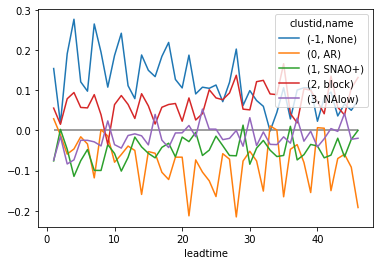

In [21]:
lineplot(coef['coef'], nameseries=code_table)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='leadtime'>)

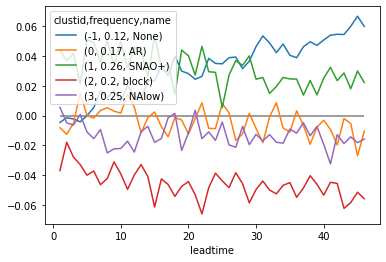

In [19]:
lineplot(freq['freqdiff'], freqframe=freq.groupby('clustid').mean()[['climatology']], nameseries=code_table)

In [26]:
frame21, freq21 = load_regimes_and_compute(interm_vars.loc['zreg21D','books'], return_frequencies=True, add_trend =False, return_trend=False)
bss21 = compute_bss(frame21)
forhor21 = compute_skill_horizon(bss21)

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='leadtime'>)

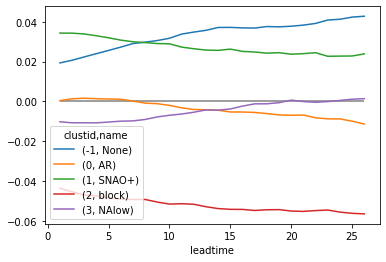

In [27]:
lineplot(freq21['freqdiff'], nameseries=code_table)

In [28]:
forhor21

,bss_fix
clustid,
-1,26
0,14
1,9
2,6
3,9


### Simple average intermediate variables

#### SST

And potential trends.

SST shows really prolonged skill. If this is mostly year to year variation it does not imply usefullness of such predictions (not even their usefulness over the observed patterns.
We also see that the skill is increased for the lower frequency time aggregation.

Differences between the spatial clusters. Between the clusters we see that 0 has the least skill. This is the region right off newfoundland with probably also a lot of wind-driven variability (as maurice said). Zero is also a bit more biased than 1 it seems.
Cluster 2 seems most trended (largest difference between bss_fix and bss_trend).

In [11]:
frame, coef = load_mean_and_compute(interm_vars.loc['sst21D','books'], climname =interm_vars.loc['sst21D','clim'],  add_trend = True, return_trend=True)
bss_sst = compute_bss(frame)

climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/stra

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='leadtime'>)

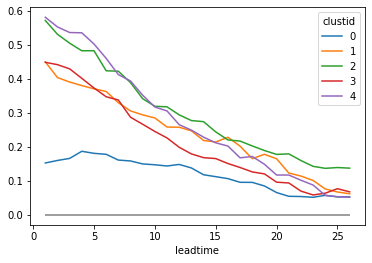

In [13]:
lineplot(bss_sst['bss_trend'])

In [38]:
frame7, coef7 = load_mean_and_compute(interm_vars.loc['sst7D','books'], climname =interm_vars.loc['sst7D','clim'],  add_trend = True, return_trend=True)
bss_sst7 = compute_bss(frame7)

climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/stra

/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so 

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='leadtime'>)

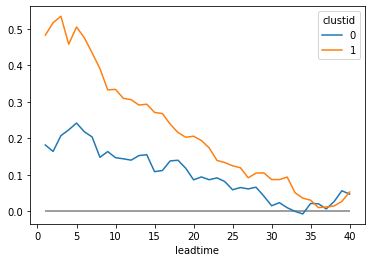

In [42]:
lineplot(bss_sst7['bss_trend'])

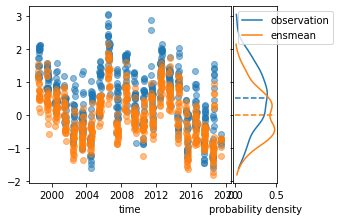

In [7]:
fancy_ensmean_plot(interm_vars.loc['sst7D','books'], leadtime = 10, clustid = 0)
plt.legend()

(<Figure size 288x25.2 with 2 Axes>,
 <Axes:xlabel='time'>,
 <Axes:xlabel='probability density'>)

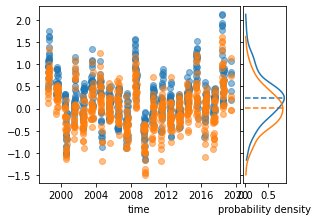

In [6]:
fancy_ensmean_plot(interm_vars.loc['sst7D','books'], leadtime = 10, clustid = 1)

The presence of a bias in the mean SST anomaly is not very surprising as they got their climatology determined by a different reference period. (median observed SST anomaly in the common period will be > 0). This behaviour will change when you binarize with a model-climatology threshold.

#### Swvl
Swvl has currently at max two (block) clusters. Just like SST it also shows extended skill (especially cluster 2) so there is potential usefulness, even while both clusters are under the influence of a frequency mismatch (this bias is constant for the first cluster, but drifts for the second cluster). The second cluster is also more (negatively) trended.

For deep soil moisture you see a dominance of year to year variability (which gets initialized) and therefore a lot of extended skill.

In [26]:
frame21, coef = load_mean_and_compute(interm_vars.loc['swvl1321D','books'], climname =interm_vars.loc['swvl1321D','clim'],  add_trend = True, return_trend=True)
bss_swvl21 = compute_bss(frame21)
forhor_21 = compute_skill_horizon(bss_swvl21)

climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/stra

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='leadtime'>)

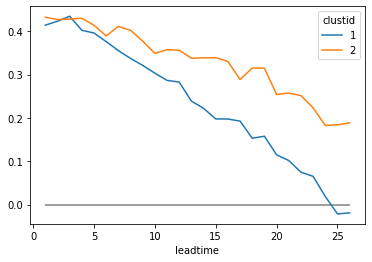

In [25]:
lineplot(bss_swvl21['bss_trend'])

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='leadtime'>)

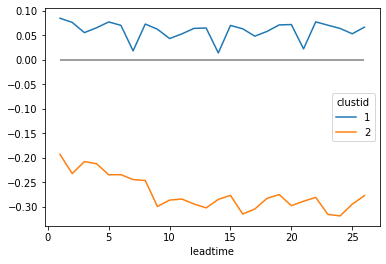

In [23]:
lineplot(coef['coef'])

(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='leadtime'>)

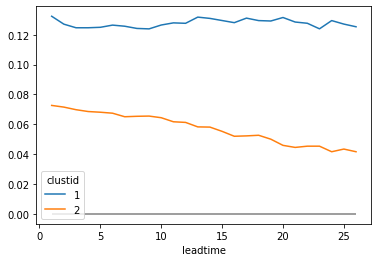

In [21]:
freqdiff = compute_frequency_mismatch(frame21)
lineplot(freqdiff)

In [16]:
frame7, coef7 = load_mean_and_compute(interm_vars.loc['swvl137D','books'], climname =interm_vars.loc['swvl137D','clim'],  add_trend = True, return_trend=True)
bss_swvl7 = compute_bss(frame7)

climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


(<Figure size 432x288 with 1 Axes>, <AxesSubplot:xlabel='leadtime'>)

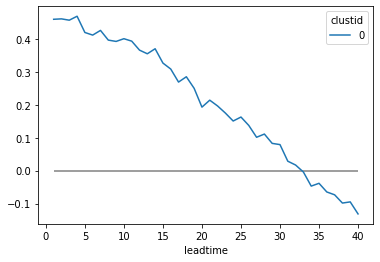

In [19]:
lineplot(bss_swvl7['bss_trend'])

Time aggregation does not do a lot for swvl13. We actually see that the forecast horizon can decrease (perhaps because frequency mismatch gets more dominant relative to the signal?).

In [27]:
frame14, coef = load_mean_and_compute(interm_vars.loc['swvl1314D','books'], climname =interm_vars.loc['swvl1314D','clim'],  add_trend = True, return_trend=True)
bss_swvl14 = compute_bss(frame14)
forhor_14 = compute_skill_horizon(bss_swvl14)

climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/straaten/Documents/Weave/Weave/models.py:70: UserWarning: BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?
  warnings.warn('BaseExceedenceModel shows a negative dependence on time, so a negative climate change trend. Is your procedure for creating y correct?')
/usr/people/stra

/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [28]:
forhor_14

,bss_fix,bss_trend
clustid,,
1,29,29
2,33,33


In [29]:
forhor_21

,bss_fix,bss_trend
clustid,,
1,25,25
2,26,26


Comparing with rank histograms we see an initial underdispersion (which disappears) and positive bias (observation has often a lower amount of soil moisture than in the ensemble). This corresponds to the too frequent exceedence of the quantile in the forecasts. There could be consistency between this bias and the temperature bias.

In [31]:
ranks, binedges = load_compute_rank(interm_vars.loc['swvl1314D','books'])

array([[<AxesSubplot:title={'center':'1'}>,
        <AxesSubplot:title={'center':'2'}>]], dtype=object)

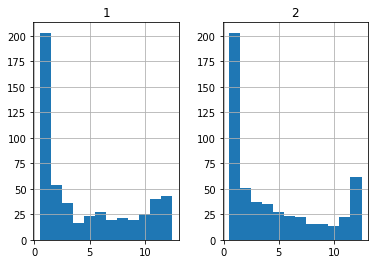

In [37]:
ranks.loc[([5],slice(None)),].unstack('clustid').hist(bins = binedges)

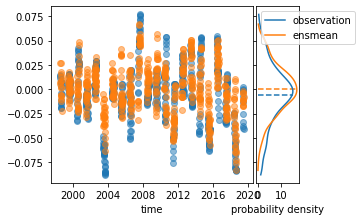

In [55]:
fancy_ensmean_plot(interm_vars.loc['swvl1314D','books'], leadtime = 30, clustid = 1)
plt.legend()

## Regime frequency = f(other), conditional biases?
Compute the frequency mismatches per datapoint, and subset this set with the values or exceedences or values of another variable.
Or plot frequency mistmatch against the ensemble mean, which is less dependent on preparing the right thresholds / climatologies.

#### Swvl13
function of the ensmean in the two soilm average regions. 
* Leadtime = 1. With increasing leadtimes the ensmean might be uninformative, but on the other hand the model misrepresentations might have had more chance to develop.
* Simultaneous though freq = 21D and swvl13 is in the first 2 weeks = 14D

In [158]:
condframe = regime_conditional_on(regbookfile=interm_vars.loc['zreg21D','books'], otherbookfile=interm_vars.loc['swvl1314D','books'], otherclimname=interm_vars.loc['swvl1314D','clim'])

climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [174]:
oneframe = condframe.loc[(slice(None),1),:]

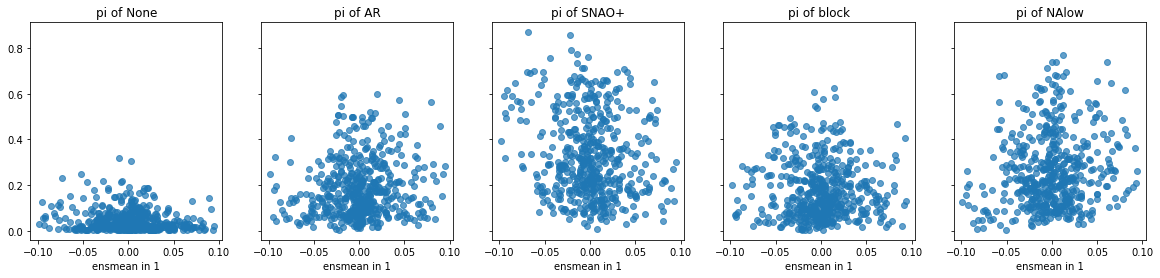

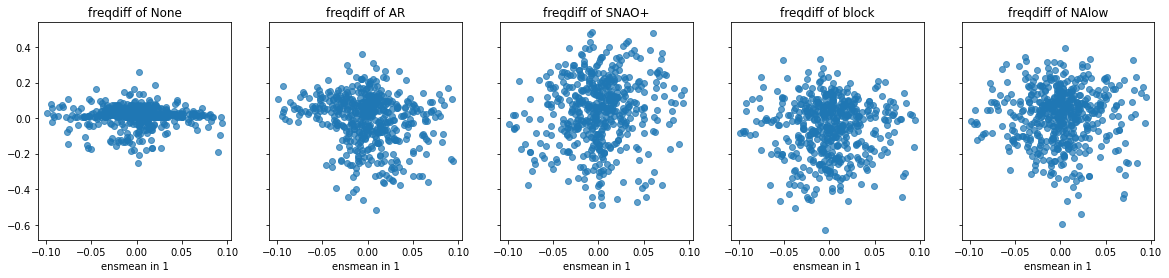

In [179]:
conditional_plots(condframe = oneframe, what = 'pi', onclustid = 1)
plt.show()
conditional_plots(condframe = oneframe, what = 'freqdiff', onclustid = 1)
plt.show()

* No low SNAO+ probabilities when ensmean says depleted soil moisture in western europe
* wetter west europe soil more NA-low?. Could actually be the consequence, i.e. wetter because more NAlow

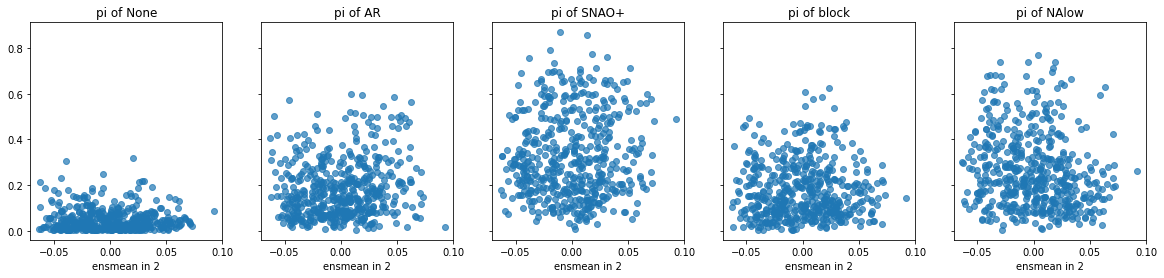

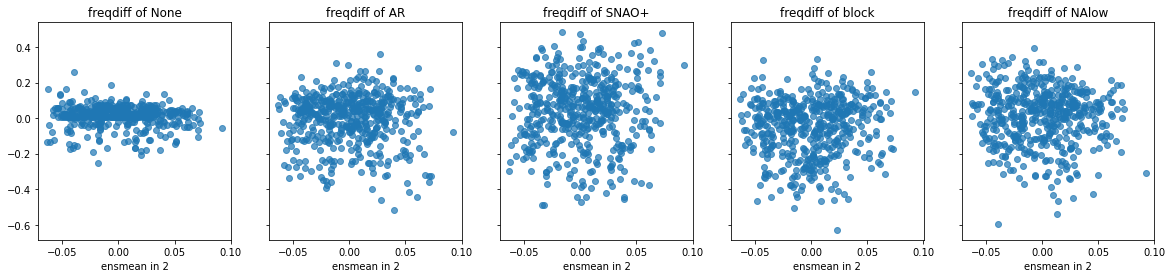

In [178]:
conditional_plots(condframe = oneframe, what = 'pi', onclustid = 2)
plt.show()
conditional_plots(condframe = oneframe, what = 'freqdiff', onclustid = 2)
plt.show()

* wet balkan ~ more blocking?
* Wetter balkan soils ~ Less underforecasting of the blocking event?

#### SST
function of the ensmean in the five sst average regions. Leadtime = 15

In [180]:
condframe = regime_conditional_on(regbookfile=interm_vars.loc['zreg21D','books'], otherbookfile=interm_vars.loc['sst21D','books'], otherclimname=interm_vars.loc['sst21D','clim'])

climatology directly loaded
lazy pi and bool observation construction


/nobackup_1/users/straaten/VENV/lib64/python3.9/site-packages/pandas/core/generic.py:4153: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  obj = obj._drop_axis(labels, axis, level=level, errors=errors)


In [191]:
fifteenframe = condframe.loc[(slice(None),15),:]

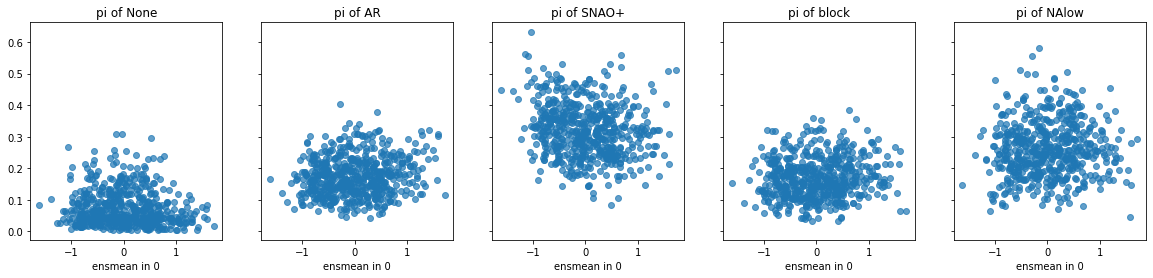

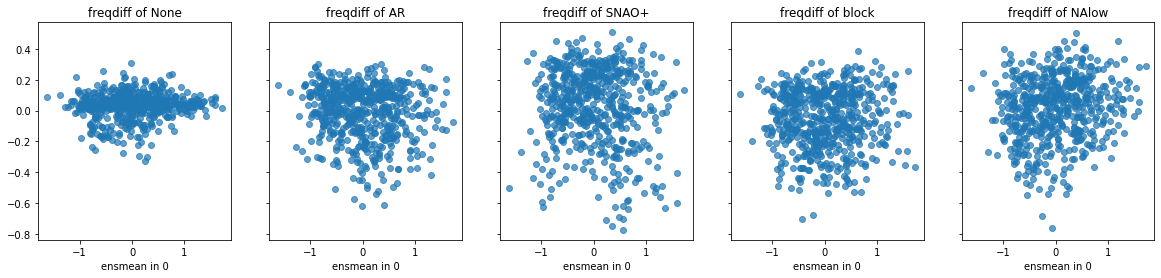

In [192]:
conditional_plots(condframe = fifteenframe, what = 'pi', onclustid = 0)
plt.show()
conditional_plots(condframe = fifteenframe, what = 'freqdiff', onclustid = 0)
plt.show()

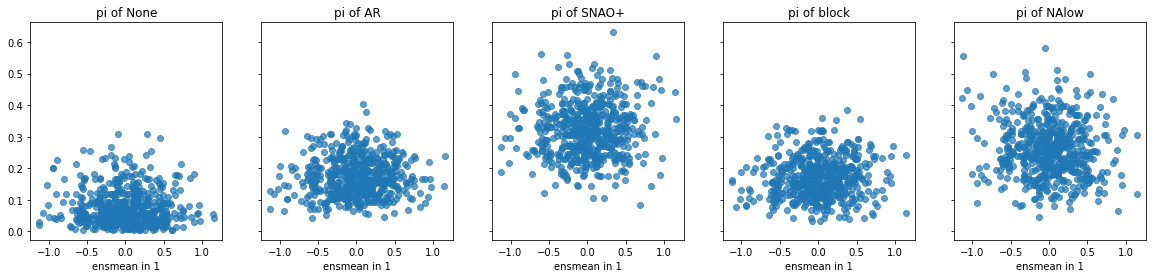

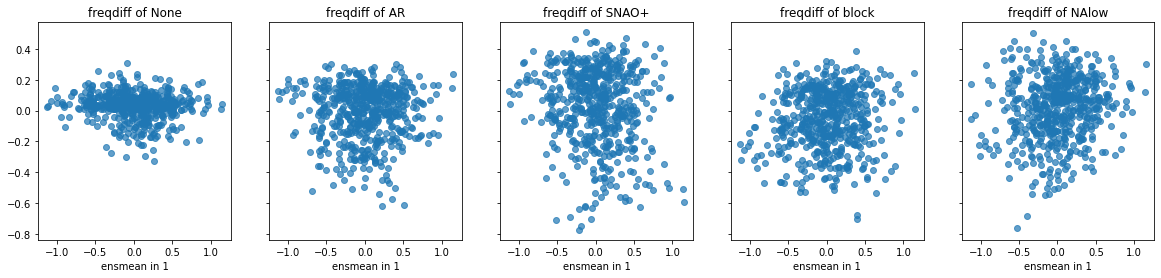

In [184]:
conditional_plots(condframe = fifteenframe, what = 'pi', onclustid = 1)
plt.show()
conditional_plots(condframe = fifteenframe, what = 'freqdiff', onclustid = 1)
plt.show()

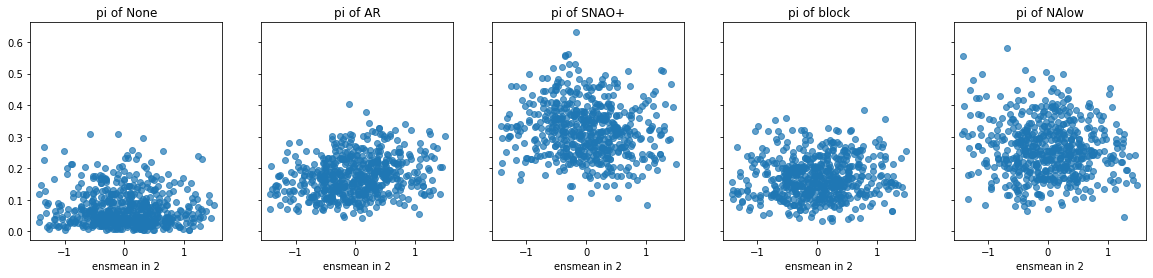

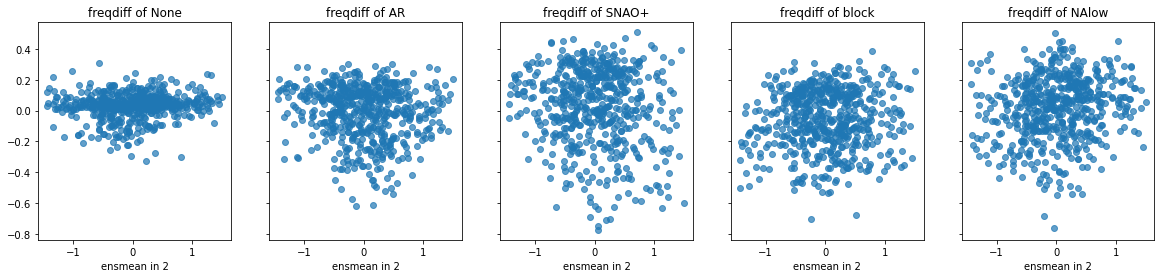

In [185]:
conditional_plots(condframe = fifteenframe, what = 'pi', onclustid = 2)
plt.show()
conditional_plots(condframe = fifteenframe, what = 'freqdiff', onclustid = 2)
plt.show()

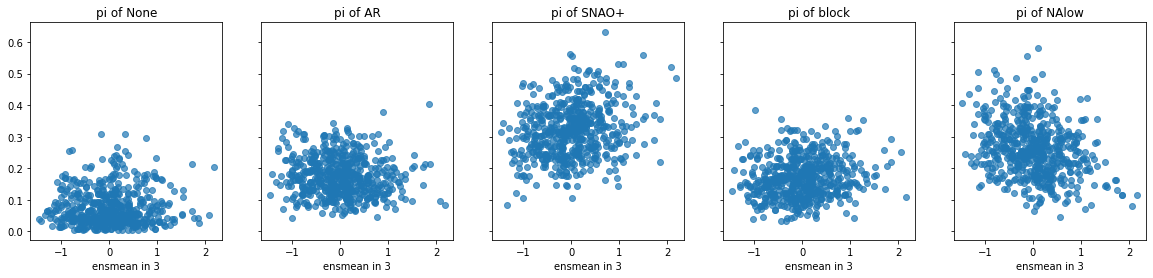

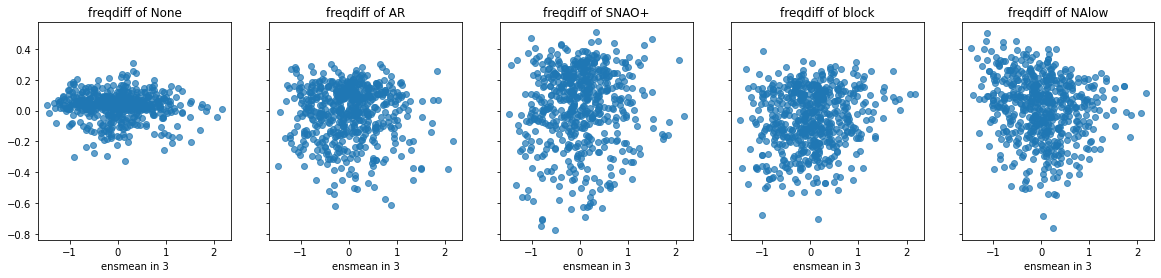

In [193]:
conditional_plots(condframe = fifteenframe, what = 'pi', onclustid = 3)
plt.show()
conditional_plots(condframe = fifteenframe, what = 'freqdiff', onclustid = 3)
plt.show()

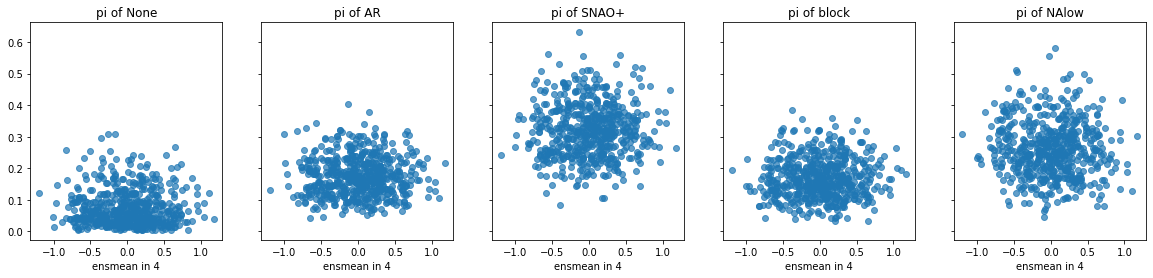

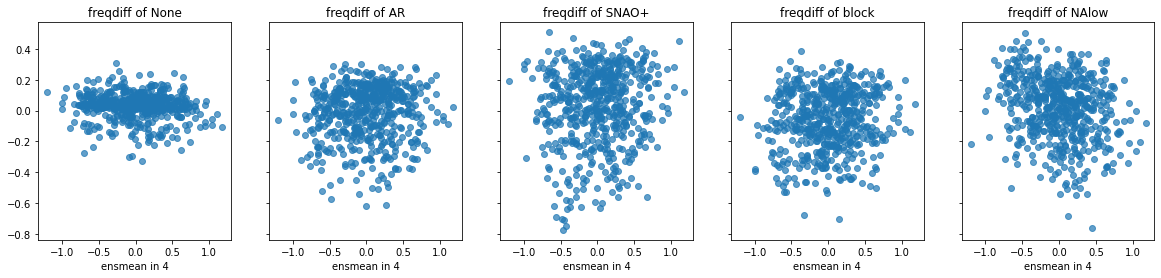

In [187]:
conditional_plots(condframe = fifteenframe, what = 'pi', onclustid = 4)
plt.show()
conditional_plots(condframe = fifteenframe, what = 'freqdiff', onclustid = 4)
plt.show()

For the underforecasting of blocking I cannot really see anything. For the overforecasted SNAO+ neither. For NA-low the bias (especially overforecasting) depends a bit on SST in clusters 3 and 4